<a href="https://colab.research.google.com/github/hayeanwoo/-Virtual-screen2/blob/master/3layer_firsttry_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt # 시각화를 위한 맷플롯립
%matplotlib inline
from sklearn.datasets import fetch_openml

In [3]:
mnist = fetch_openml('mnist_784', version=1, cache=True, as_frame  =False)

In [4]:
print(mnist.data[0])

[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
  18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
 253. 253. 253. 253. 225. 172. 253. 242. 195.  64.   0.   0.   0.   0.
   0. 

In [5]:
mnist.target[0]

'5'

In [6]:
mnist.target = mnist.target.astype(np.int8)

In [7]:
X = mnist.data / 255  # 0-255값을 [0,1] 구간으로 정규화
y = mnist.target

이 이미지 데이터의 레이블은 5이다


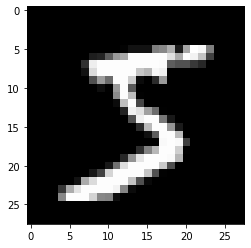

In [8]:
plt.imshow(X[0].reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 레이블은 {:.0f}이다".format(y[0]))

In [9]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/5, random_state=0)

X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

ds_train = TensorDataset(X_train, y_train)
ds_test = TensorDataset(X_test, y_test)

loader_train = DataLoader(ds_train, batch_size=64, shuffle=True)
loader_test = DataLoader(ds_test, batch_size=64, shuffle=False)

In [11]:
from torch import nn

model = nn.Sequential()
model.add_module('fc1', nn.Linear(28*28*1, 100))
model.add_module('relu1', nn.ReLU())
model.add_module('fc2', nn.Linear(100, 100))
model.add_module('relu2', nn.ReLU())
model.add_module('fc3', nn.Linear(100, 10))

print(model)

Sequential(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


In [12]:
from torch import optim

# 오차함수 선택
loss_fn = nn.CrossEntropyLoss()

# 가중치를 학습하기 위한 최적화 기법 선택
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [13]:
def train(epoch):
    model.train()  # 신경망을 학습 모드로 전환

    # 데이터로더에서 미니배치를 하나씩 꺼내 학습을 수행
    for data, targets in loader_train:

        optimizer.zero_grad()  # 경사를 0으로 초기화
        outputs = model(data)  # 데이터를 입력하고 출력을 계산
        loss = loss_fn(outputs, targets)  # 출력과 훈련 데이터 정답 간의 오차를 계산
        loss.backward()  # 오차를 역전파 계산
        optimizer.step()  # 역전파 계산한 값으로 가중치를 수정

    print("epoch{}：완료\n".format(epoch))

In [14]:
def test():
    model.eval()  # 신경망을 추론 모드로 전환
    correct = 0

    # 데이터로더에서 미니배치를 하나씩 꺼내 추론을 수행
    with torch.no_grad():  # 추론 과정에는 미분이 필요없음
        for data, targets in loader_test:

            outputs = model(data)  # 데이터를 입력하고 출력을 계산

            # 추론 계산
            _, predicted = torch.max(outputs.data, 1)  # 확률이 가장 높은 레이블이 무엇인지 계산
            correct += predicted.eq(targets.data.view_as(predicted)).sum()  # 정답과 일치한 경우 정답 카운트를 증가

    # 정확도 출력
    data_num = len(loader_test.dataset)  # 데이터 총 건수
    print('\n테스트 데이터에서 예측 정확도: {}/{} ({:.0f}%)\n'.format(correct,
                                                   data_num, 100. * correct / data_num))

In [15]:

test()


테스트 데이터에서 예측 정확도: 1294/14000 (9%)



In [16]:
for epoch in range(3):
    train(epoch)

test()

epoch0：완료

epoch1：완료

epoch2：완료


테스트 데이터에서 예측 정확도: 13339/14000 (95%)



예측 결과 : 2
이 이미지 데이터의 정답 레이블은 2입니다


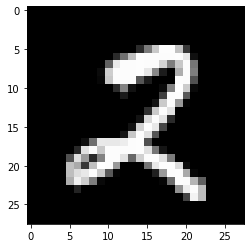

In [17]:
index = 2018

model.eval()  # 신경망을 추론 모드로 전환
data = X_test[index]
output = model(data)  # 데이터를 입력하고 출력을 계산
_, predicted = torch.max(output.data, 0)  # 확률이 가장 높은 레이블이 무엇인지 계산

print("예측 결과 : {}".format(predicted))

X_test_show = (X_test[index]).numpy()
plt.imshow(X_test_show.reshape(28, 28), cmap='gray')
print("이 이미지 데이터의 정답 레이블은 {:.0f}입니다".format(y_test[index]))

11490434/11490434 [==============================] - 0s 0us/step

Epoch 1: val_loss improved from inf to 0.14751, saving model to ./model/01-0.1475.hdf5

Epoch 2: val_loss improved from 0.14751 to 0.10185, saving model to ./model/02-0.1019.hdf5

Epoch 3: val_loss improved from 0.10185 to 0.08856, saving model to ./model/03-0.0886.hdf5

Epoch 4: val_loss improved from 0.08856 to 0.07822, saving model to ./model/04-0.0782.hdf5

Epoch 5: val_loss improved from 0.07822 to 0.07362, saving model to ./model/05-0.0736.hdf5

Epoch 6: val_loss improved from 0.07362 to 0.06725, saving model to ./model/06-0.0673.hdf5

Epoch 7: val_loss improved from 0.06725 to 0.06488, saving model to ./model/07-0.0649.hdf5

Epoch 8: val_loss improved from 0.06488 to 0.06303, saving model to ./model/08-0.0630.hdf5

Epoch 9: val_loss did not improve from 0.06303

Epoch 10: val_loss improved from 0.06303 to 0.06252, saving model to ./model/10-0.0625.hdf5

Epoch 11: val_loss did not improve from 0.06252

Epoch 12: va

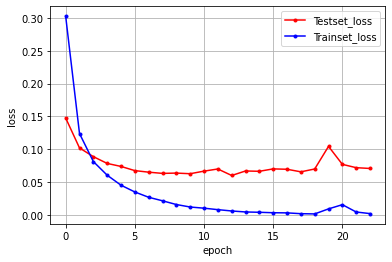

In [25]:
from keras.datasets import mnist
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint,EarlyStopping
import matplotlib.pyplot as plt
import numpy
import os
import tensorflow as tf
# seed 값 설정
seed = 0
numpy.random.seed(seed)
tf.random.set_seed(3)
# MNIST 데이터 불러오기
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 784).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 784).astype('float32') / 255
Y_train = np_utils.to_categorical(Y_train, 10)
Y_test = np_utils.to_categorical(Y_test, 10)
# 모델 프레임 설정
model = Sequential()
model.add(Dense(512, input_dim=784, activation='relu'))
model.add(Dense(10, activation='softmax'))
# 모델 실행 환경 설정
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# 모델 최적화 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
modelpath="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
# 모델의 실행
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30, batch_size=200, verbose=0, callbacks=[early_stopping_callback,checkpointer])
# 테스트 정확도 출력
print("\n Test Accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))
# 테스트 셋의 오차
y_vloss = history.history['val_loss']
# 학습셋의 오차
y_loss = history.history['loss']
# 그래프로 표현
x_len = numpy.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')
# 그래프에 그리드를 주고 레이블을 표시
plt.legend(loc='upper right')
# plt.axis([0, 20, 0, 0.35])
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()
